**Name:** LI XINYAN

**EID:** 55670594

**Kaggle Team Name:** Saaries98

# CS5489 - Assignment 1 - Tweet Sentiment Analysis

## Goal
In this assignment, the task is predict the sentiment of Tweets about four technology companies, Apple, Microsoft, Google, and Twitter. Here are some examples of tweets with different sentiments:
  - **positive**: _"http://t.co/QV4m1Un9 Forget the phone.. Nice UI. Liking the Scroll Feature #android #google #nexus"_
  - **negative**: _"Have never had such poor customer service at @Apple before! What happened? (@ Apple Store w/ 2 others) http://t.co/GKlXMUi6"_
  - **neutral**: _"The lock screen now has facial recognition capability! #Google #Android #ICS"_.

Your goal is to train a classifier to predict whether a tweet is positive, neutral, or negative sentiment.


## Methodology
You need to train classifiers using the training data, and then predict on the test data. You are free to choose the feature extraction method and classifier algorithm.  You are free to use methods that were not introduced in class.  You should probably do cross-validation to select a good parameters.


## Evaluation on Kaggle

You need to submit your test predictions to Kaggle for evaluation.  50% of the test data will be used to show your ranking on the live leaderboard.  After the assignment deadline, the remaining 50% will be used to calculate your final ranking. Also the top-ranked entries will be asked to give a short 5 minute presentation on what they did.

To submit to Kaggle you need to create an account, and use the competition invitation that will be posted on Canvas.

**Note:** You can only submit 2 times per day to Kaggle!

## What to hand in
You need to turn in the following things:

1. This ipynb file with your source code and documentation. _**You should write about all the various attempts that you make to find a good solution.**_ You may also submit python scripts as source code, but your documentation must be in the ipynb file.
2. Your final submission file to Kaggle.
3. The ipynb file `Assignment1-Final.ipynb`, which contains the code that generates the final submission file that you submit to Kaggle.  **This code will be used to verify that your Kaggle submission is reproducible.**

Files should be uploaded to Assignment 1 on Canvas.

## Grading
The marks of the assignment are distributed as follows:
- 45% - Results using various classifiers and feature representations.
- 30% - Trying out feature representations (e.g. adding additional features) or classifiers not used in the tutorials/lectures.
- 20% - Quality of the written report.  More points for insightful observations and analysis.
- 5% - Final ranking on the Kaggle test data (private leaderboard). If a submission cannot be reproduced by the submitted code, it will not receive marks for ranking.
- **Late Penalty:** 25 marks will be subtracted for each day late.

**Note:** you should start early! Some classifiers may take a while to train.


## Kaggle Notebooks

If you like, you can use Kaggle notebooks to run your code. Note that you still need to submit your code to Canvas for grading.
<hr>

# Load the Data

The training data is in the text file `sanders_tweets_train.txt`.  This CSV file contains the  tweet, labels, and topics. The class labels are: `"positive"`, `"neutral"`, and `"negative"`. The training data also includes the corresponding tweet topics: `"apple"`, `"microsoft"`, `"google"`, and `"twitter"`.

The testing data is in the text file `sanders_tweets_test.txt`, and only contains the tweets.  The topics are not included, since they are not known at test time.

To submit to Kaggle, you need to generate a Kaggle submission files, which is CSV file with the following format: 

<pre>
Id,Prediction
1,neutral
2,neutral
3,positive
4,negative
...
</pre>

Here are two helpful functions for reading the text data and writing the Kaggle submission file.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
import csv
random.seed(100)

In [2]:
def read_text_data(fname):
    txtdata = []
    classes = []
    topics  = []
    with open(fname, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row in reader:
            # get the text
            txtdata.append(row[0])
            # get the class (convert to integer)
            if len(row)>1:
                classes.append(row[1])
                topics.append(row[2])
    
    if (len(classes)>0) and (len(txtdata) != len(classes)):        
        raise Exception("mismatched length!")
    
    return (txtdata, classes, topics)

def write_csv_kaggle_sub(fname, Y):
    # fname = file name
    # Y is a list/array with class entries
    
    # header
    tmp = [['Id', 'Prediction']]
    
    # add ID numbers for each Y
    for (i,y) in enumerate(Y):
        tmp2 = [(i+1), y]
        tmp.append(tmp2)
        
    # write CSV file
    with open(fname, 'w') as f:
        writer = csv.writer(f)
        writer.writerows(tmp)

The below code will load the training and test sets.

In [3]:
# load the data
# (if using Kaggle notebooks you need to include the directory path: /kaggle/input/cs5489-2020b-assignment-1/)
(traintxt, trainY, traintopic) = read_text_data("sanders_tweets_train.txt")
(testtxt, _, _)                = read_text_data("sanders_tweets_test.txt")

print(len(traintxt))
print(len(testtxt))

2396
1028


In [4]:
classnames = unique(trainY)
print(classnames)

['negative' 'neutral' 'positive']


Here is an example to write a csv file with predictions on the test set.  These are random predictions.

In [5]:
# write your predictions on the test set
i = random.randint(len(classnames), size=len(testtxt))
predY = classnames[i]
write_csv_kaggle_sub("my_submission.csv", predY)

Look at the data:

In [6]:
print(trainY[0])
print(traintopic[0])
print(traintxt[0])

positive
google
http://t.co/QV4m1Un9 Forget the phone.. Nice UI. Liking the Scroll Feature #android #google #nexus


# YOUR CODE and DOCUMENTATION HERE

## Feature Exploration

1. Except for building the TF-IDF or the BoW feature, I extracted some meta information for my classifier to make more accurate predictions.

2. For example: I counted the number of exclamation(!), questionmark(?), hashtag(#), quote("), full stop(.), mention(@).

3. Some NLP library provides easy-to-use API to evaluate the sentiment of s sentence, so I made use of them as one of the feature: Affin [https://github.com/fnielsen/afinn], TextBlob [https://textblob.readthedocs.io/en/dev/].

4. During the data distribution analysis, I found that the tweets corpus has special preference for specific company (there are more positive tweets about Google but more negative tweets about Apple).

5. **The following section shows how I explore the database and determine what features to use.**


# Data pre-processing

### I use pandas to reduce the processing workload.

In [7]:
import pandas as pd
import numpy as np

c1 = np.array(traintxt)
c2 = np.array(traintopic)
c3 = np.array(trainY)

dix = {"traintxt": c1,
       "traintopic":c2,
       "trainY":c3}

train_data = pd.DataFrame(dix)

In [8]:
# See what we have
display(train_data)

,traintxt,traintopic,trainY
0,http://t.co/QV4m1Un9 Forget the phone.. Nice U...,google,positive
1,I hate when my phne do what it want on #twitter,twitter,neutral
2,…and only the first 23 images in my Photo Roll...,apple,negative
3,The lock screen now has facial recognition cap...,google,neutral
4,#TeamGoogleNexus RT @B__Y #Google + #Samsung =...,google,neutral
...,...,...,...
2391,@karth_vader_ when did you change your nick ag...,twitter,neutral
2392,GoodNight #Twitter:),twitter,neutral
2393,@AndroidPolice Duly noted -- I hope AOSP is up...,google,neutral
2394,#Microsoft's plan for bringing its #BI tools t...,microsoft,neutral


In [9]:
# Check which python Jupyter Notebook is using, then install package for it
import sys
sys.executable
# /opt/anaconda3/bin/python -m pip install afinn

'/opt/anaconda3/bin/python'

# Helper Functions

### Helper functions for data pre-processing

1. eva_afinn_score(): calculate the Afinn sentiment score
2. eva_blob_score(): calculate the TextBlob sentiment score
3. add_extra_feature(): the punctuation might relate to sentiment, so we extract them as features
4. eva_comp(): the mentioned company name might relate to sentiment, so we extract them as features

In [10]:
from afinn import Afinn
from textblob import TextBlob

def eva_afinn_score(string):
    af = Afinn(emoticons=True)
    scr = af.score(string)
    return scr


def eva_blob_score(string):
    scr = TextBlob(string).sentiment.polarity
    return scr

In [11]:
import re
def add_extra_feature(df, tweet_column):
    
    # Number of ""
    df['number_of_quote'] = tweet_column.apply(lambda x: (len(re.findall(r'"', x))/2))
    
    # Number of .
    df['number_of_stop'] = tweet_column.apply(lambda x: (len(re.findall(r'.', x))))
    
    # Number of !
    df['number_of_exclamation'] = tweet_column.apply(lambda x: (len(re.findall(r'!', x))))
    
    # Number of ?
    df['number_of_questionmark'] = tweet_column.apply(lambda x: (len(re.findall(r'[?]', x))))
    
    # Number of #
    df['number_of_hashtag'] = tweet_column.apply(lambda x: (len(re.findall(r'#', x))))
    
    # Number of @
    df['number_of_mention'] = tweet_column.apply(lambda x: (len(re.findall(r'@', x))))
    
    # Number of @
    df['number_of_comma'] = tweet_column.apply(lambda x: (len(re.findall(r',', x))))

In [12]:
def eva_comp(df, tweet_column):
    df['apple'] = tweet_column.apply(lambda x: int('apple' in x))
    df['google'] = tweet_column.apply(lambda x: int('google' in x))
    df['twitter'] = tweet_column.apply(lambda x: int('twitter' in x))
    df['microsoft'] = tweet_column.apply(lambda x: int('microsoft' in x))

### Helper functions for data cleaning, tokenize, and stemming
5. clean_str(): remove the unwanted noise/punctuation/symbol in our data corpus
6. tokenize(): tokenize the tweet sentences into words
7. stemming(): apply stemming to words
8. word_to_sen(): transform word lists back to sentences

In [13]:
def clean_str(string):
    # Special emoji for heart
    string = re.sub("&lt;3","love", string)
    
    # Remove hyperlink
    string = re.sub("http://[\w|./]*","", string)
    
    # Only keep alphabet
    string = re.sub(r"[^A-Za-z]", " ", string)
    
#     string = re.sub(r'(.)\1+', r'\1\1', string) 
#     string = re.sub(r"\'s", " \'s", string)
#     string = re.sub(r"\'ve", " \'ve", string)
#     string = re.sub(r"n\'t", " n\'t", string)
#     string = re.sub(r"\'re", " \'re", string)
#     string = re.sub(r"\'d", " \'d", string)
#     string = re.sub(r"\'ll", " \'ll", string)
#     string = re.sub(r"!", " ! ", string)
#     string = re.sub(r"\)", " \) ", string)
#     string = re.sub(r"\?", " \? ", string)
#     string = re.sub(r"\s{2,}", " ", string)

    # return lower case
    return string.strip().lower()

In [14]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

def tokenize(text):
    return word_tokenize(text)

def stemming(words):
    ps = PorterStemmer()
    stem_words = []
    for w in words:
        w = ps.stem(w)
        stem_words.append(w)
    return stem_words

def word_to_sen(words):
    sen = ''
    for w in words:
        sen = sen + w + ' '
    return sen

### Apply the above help functions to our dataset

In [15]:
# Helper function: 1~3
add_extra_feature(train_data, train_data["traintxt"])
train_data['affin'] = train_data['traintxt'].apply(eva_afinn_score)
train_data['blob'] = train_data['traintxt'].apply(eva_blob_score)

# Helper function: 5
train_data['traintxt'] = train_data['traintxt'].apply(clean_str)

# Helper function: 4
eva_comp(train_data, train_data["traintxt"])

# Helper function: 6~8
train_data["traintxt"] = train_data["traintxt"].apply(tokenize)
train_data["traintxt"] = train_data["traintxt"].apply(stemming)
train_data["traintxt"] = train_data["traintxt"].apply(word_to_sen)

# The tweets length might also be helpeful
train_data['length'] =  train_data["traintxt"].apply(lambda x: (len(x)))

In [16]:
# Ptint pre-processing results
display(train_data)

,traintxt,traintopic,trainY,number_of_quote,number_of_stop,number_of_exclamation,number_of_questionmark,number_of_hashtag,number_of_mention,number_of_comma,affin,blob,apple,google,twitter,microsoft,length
0,forget the phone nice ui like the scroll featu...,google,positive,0.0,98,0,0,3,0,0,4.0,0.600000,0,1,0,0,67
1,i hate when my phne do what it want on twitter,twitter,neutral,0.0,47,0,0,1,0,0,-2.0,-0.800000,0,0,1,0,47
2,and onli the first imag in my photo roll made ...,apple,negative,0.0,113,0,2,0,1,2,-4.0,-0.056667,1,0,0,0,99
3,the lock screen now ha facial recognit capabl ...,google,neutral,0.0,76,1,0,3,0,0,3.0,0.000000,0,1,0,0,63
4,teamgooglenexu rt b y googl samsung perfect ic...,google,neutral,0.0,86,0,0,5,1,0,3.0,1.000000,0,1,0,0,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391,karth vader when did you chang your nick again...,twitter,neutral,0.0,131,0,2,1,1,0,-3.0,-0.500000,0,0,1,0,120
2392,goodnight twitter,twitter,neutral,0.0,20,0,0,1,0,0,2.0,0.500000,0,0,1,0,18
2393,androidpolic duli note i hope aosp is updat wi...,google,neutral,0.0,82,0,0,2,1,0,2.0,0.000000,0,1,0,0,66
2394,microsoft s plan for bring it bi tool to io an...,microsoft,neutral,0.0,128,0,0,2,0,2,0.0,0.500000,0,0,0,1,82


# Database Visualization and Feature Analysis

### The label distribution of the entire training set

1. We can see that there are more samples with sentiment == neutral.
2. We have similar amount of positive and negative samples.
3. I think this distribution might result in an unbalanced classifier, so I try to reduce the impacts of data unbalanced when trying the classifier.

[363, 1630, 403]


Text(0.5, 1.0, 'Sentiment distribution')

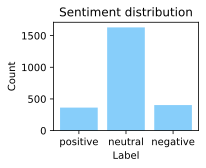

In [17]:
# import seaborn as sns
# sns.countplot(x = 'trainY', data = train_data)
# plt.title("Sentiment distribution")

plt.figure(figsize=(12, 2))
labels = ["positive", "neutral", "negative"]

cnt = []
for lab in labels:
    cnt.append(len(train_data[train_data["trainY"] == lab]))

print(cnt)
    
plt.subplot(1,4,1)
plt.bar(labels, cnt, color="#87CEFA")
plt.xlabel('Label')
plt.ylabel('Count')
plt.title("Sentiment distribution")

### The distribution of the special punctuations over the labels

1. The number of questionmark, quote, and comma are highly connected to positive/negative sentiments.
2. The number of hashtag, full stop show less connection to positive/negative sentiments.
3. All the tweets must contain at least one of the symbols in [exclamation, questionmark, hashtag, mention].
4. Tweets that mention Google, Apple, and Microsoft have special sentiments preference.

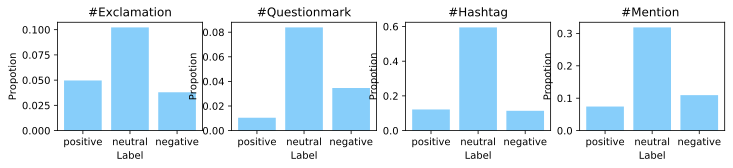

In [18]:
plt.figure(figsize=(12, 2))
labels = ["positive", "neutral", "negative"]

condition = "number_of_exclamation"
filtered_data = train_data[train_data[condition] > 0]
cnt = []
for lab in labels:
    cnt.append(len(filtered_data[filtered_data["trainY"] == lab]) / len(train_data["trainY"] == lab))

plt.subplot(1,4,1)
plt.bar(labels, cnt, color="#87CEFA")
plt.xlabel('Label')
plt.ylabel('Propotion')
plt.title('#Exclamation')


condition = "number_of_questionmark"
filtered_data = train_data[train_data[condition] > 0]
cnt = []
for lab in labels:
    cnt.append(len(filtered_data[filtered_data["trainY"] == lab]) / len(train_data["trainY"] == lab))

plt.subplot(1,4,2)
plt.bar(labels, cnt, color="#87CEFA")
plt.xlabel('Label')
plt.ylabel('Propotion')
plt.title('#Questionmark')

condition = "number_of_hashtag"
filtered_data = train_data[train_data[condition] > 0]
cnt = []
x = 0
for lab in labels:
    cnt.append(len(filtered_data[filtered_data["trainY"] == lab]) / len(train_data["trainY"] == lab))
    x += len(filtered_data[filtered_data["trainY"] == lab])
    
plt.subplot(1,4,3)
plt.bar(labels, cnt, color="#87CEFA")
plt.xlabel('Label')
plt.ylabel('Propotion')
plt.title('#Hashtag')


condition = "number_of_mention"
filtered_data = train_data[train_data[condition] > 0]
cnt = []
x = 0
for lab in labels:
    cnt.append(len(filtered_data[filtered_data["trainY"] == lab]) / len(train_data["trainY"] == lab))
    x += len(filtered_data[filtered_data["trainY"] == lab])
plt.subplot(1,4,4)

plt.bar(labels, cnt, color="#87CEFA")
plt.xlabel('Label')
plt.ylabel('Propotion')
plt.title('#Mention ')

plt.show()

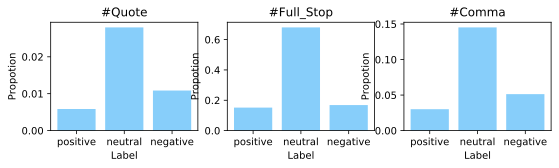

In [19]:
plt.figure(figsize=(9, 2))
labels = ["positive", "neutral", "negative"]

condition = "number_of_quote"
filtered_data = train_data[train_data[condition] > 0]
cnt = []
for lab in labels:
    cnt.append(len(filtered_data[filtered_data["trainY"] == lab]) / len(train_data["trainY"] == lab))

plt.subplot(1,3,1)
plt.bar(labels, cnt, color="#87CEFA")
plt.xlabel('Label')
plt.ylabel('Propotion')
plt.title('#Quote')


condition = "number_of_stop"
filtered_data = train_data[train_data[condition] > 0]
cnt = []
for lab in labels:
    cnt.append(len(filtered_data[filtered_data["trainY"] == lab]) / len(train_data["trainY"] == lab))

plt.subplot(1,3,2)
plt.bar(labels, cnt, color="#87CEFA")
plt.xlabel('Label')
plt.ylabel('Propotion')
plt.title('#Full_Stop')

condition = "number_of_comma"
filtered_data = train_data[train_data[condition] > 0]
cnt = []
for lab in labels:
    cnt.append(len(filtered_data[filtered_data["trainY"] == lab]) / len(train_data["trainY"] == lab))

plt.subplot(1,3,3)
plt.bar(labels, cnt, color="#87CEFA")
plt.xlabel('Label')
plt.ylabel('Propotion')
plt.title('#Comma')


plt.show()

In [20]:
print(len(train_data))
filtered_data = train_data[train_data["number_of_exclamation"] == 0]
print(len(filtered_data))

filtered_data = filtered_data[filtered_data["number_of_questionmark"] == 0]

print(len(filtered_data))
filtered_data = filtered_data[filtered_data["number_of_hashtag"] ==0]
print(len(filtered_data))

filtered_data = filtered_data[filtered_data["number_of_mention"] == 0]
print(len(filtered_data))

2396
1941
1679
240
0


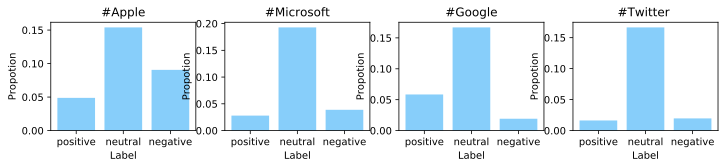

In [21]:
# Apple, Microsoft, Google, and Twitter

plt.figure(figsize=(12, 2))
labels = ["positive", "neutral", "negative"]

condition = "apple"
filtered_data = train_data[train_data["traintopic"] == condition]

cnt = []
for lab in labels:
    cnt.append(len(filtered_data[filtered_data["trainY"] == lab]) / len(train_data["trainY"] == lab))

plt.subplot(1,4,1)
plt.bar(labels, cnt, color="#87CEFA")
plt.xlabel('Label')
plt.ylabel('Propotion')
plt.title('#Apple')


condition = "microsoft"
filtered_data = train_data[train_data["traintopic"] == condition]
cnt = []
for lab in labels:
    cnt.append(len(filtered_data[filtered_data["trainY"] == lab]) / len(train_data["trainY"] == lab))

plt.subplot(1,4,2)
plt.bar(labels, cnt, color="#87CEFA")
plt.xlabel('Label')
plt.ylabel('Propotion')
plt.title('#Microsoft')

condition = "google"
filtered_data = train_data[train_data["traintopic"] == condition]
cnt = []
x = 0
for lab in labels:
    cnt.append(len(filtered_data[filtered_data["trainY"] == lab]) / len(train_data["trainY"] == lab))
    x += len(filtered_data[filtered_data["trainY"] == lab])
    
plt.subplot(1,4,3)
plt.bar(labels, cnt, color="#87CEFA")
plt.xlabel('Label')
plt.ylabel('Propotion')
plt.title('#Google')


condition = "twitter"
filtered_data = train_data[train_data["traintopic"] == condition]
cnt = []
x = 0
for lab in labels:
    cnt.append(len(filtered_data[filtered_data["trainY"] == lab]) / len(train_data["trainY"] == lab))
    x += len(filtered_data[filtered_data["trainY"] == lab])
plt.subplot(1,4,4)

plt.bar(labels, cnt, color="#87CEFA")
plt.xlabel('Label')
plt.ylabel('Propotion')
plt.title('#Twitter ')

plt.show()

# Feature Encoding

### 1. Use TF-IDF representation

In [22]:
display(train_data)

,traintxt,traintopic,trainY,number_of_quote,number_of_stop,number_of_exclamation,number_of_questionmark,number_of_hashtag,number_of_mention,number_of_comma,affin,blob,apple,google,twitter,microsoft,length
0,forget the phone nice ui like the scroll featu...,google,positive,0.0,98,0,0,3,0,0,4.0,0.600000,0,1,0,0,67
1,i hate when my phne do what it want on twitter,twitter,neutral,0.0,47,0,0,1,0,0,-2.0,-0.800000,0,0,1,0,47
2,and onli the first imag in my photo roll made ...,apple,negative,0.0,113,0,2,0,1,2,-4.0,-0.056667,1,0,0,0,99
3,the lock screen now ha facial recognit capabl ...,google,neutral,0.0,76,1,0,3,0,0,3.0,0.000000,0,1,0,0,63
4,teamgooglenexu rt b y googl samsung perfect ic...,google,neutral,0.0,86,0,0,5,1,0,3.0,1.000000,0,1,0,0,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391,karth vader when did you chang your nick again...,twitter,neutral,0.0,131,0,2,1,1,0,-3.0,-0.500000,0,0,1,0,120
2392,goodnight twitter,twitter,neutral,0.0,20,0,0,1,0,0,2.0,0.500000,0,0,1,0,18
2393,androidpolic duli note i hope aosp is updat wi...,google,neutral,0.0,82,0,0,2,1,0,2.0,0.000000,0,1,0,0,66
2394,microsoft s plan for bring it bi tool to io an...,microsoft,neutral,0.0,128,0,0,2,0,2,0.0,0.500000,0,0,0,1,82


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
train_tf_idf_features = vectorizer.fit_transform(train_data["traintxt"]).toarray()
train_tf_idf = pd.DataFrame(train_tf_idf_features)

In [24]:
display(train_tf_idf)

,0,1,2,3,4,5,6,7,8,9,...,4596,4597,4598,4599,4600,4601,4602,4603,4604,4605
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2. Use BoW representation

In [25]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import preprocessing

comp_vectorizer = CountVectorizer(max_features=3000, stop_words="english")
train_bow_features = comp_vectorizer.fit_transform(train_data["traintxt"]).toarray()
train_bow = pd.DataFrame(train_bow_features)

In [26]:
display(train_bow)

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2392,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2393,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2394,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Train Baseline Models

### TFIDF - RandomForestClassifier - baseline without cross validation

In [27]:
# # Consider class unbalanced
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# # 0.78, 6th submission
# selected_features = ['number_of_exclamation', 'number_of_questionmark', 'number_of_hashtag',
#                      'number_of_quote', 'number_of_stop', 'number_of_mention',
#                      'affin', 'blob', 'apple', 'google', 'microsoft']

# train = pd.merge(train_tf_idf, train_data[selected_features], left_index=True, right_index=True)
# train_X, test_X, train_Y, test_Y = train_test_split(train, trainY, test_size=0.2)

# tfidf_rf_clf_model = RandomForestClassifier(n_estimators = 1000, min_samples_split = 10, bootstrap = True,
#                                       max_depth = 100, random_state = 0, class_weight='balanced')

# tfidf_rf_clf_model.fit(train_X, train_Y)
# pred_Y = tfidf_rf_clf_model.predict(test_X)

# print("Accuracy => ", accuracy_score(pred_Y, test_Y))
# print("\nRandom Forest Classifier results:")
# print(classification_report(test_Y, pred_Y))

### BoW - RandomForestClassifier - baseline without cross validation

In [28]:
# Consider class unbalanced
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# 0.78, 6th submission
selected_features = ['number_of_exclamation', 'number_of_questionmark', 'number_of_hashtag',
                     'number_of_quote', 'number_of_stop', 'number_of_mention',
                     'affin', 'blob', 'apple', 'google', 'microsoft']

train = pd.merge(train_bow, train_data[selected_features], left_index=True, right_index=True)
train_X, test_X, train_Y, test_Y = train_test_split(train, trainY, test_size=0.2)

bow_rf_clf_model = RandomForestClassifier(n_estimators = 1000, min_samples_split = 10, bootstrap = True,
                                      max_depth = 100, random_state = 0, class_weight='balanced')

bow_rf_clf_model.fit(train_X, train_Y)
pred_Y = bow_rf_clf_model.predict(test_X)

print("Accuracy => ", accuracy_score(pred_Y, test_Y))
print("\nRandom Forest Classifier results:")
print(classification_report(test_Y, pred_Y))

Accuracy =>  0.81875

Random Forest Classifier results:
              precision    recall  f1-score   support

    negative       0.72      0.74      0.73        72
     neutral       0.86      0.91      0.88       333
    positive       0.71      0.49      0.58        75

    accuracy                           0.82       480
   macro avg       0.76      0.71      0.73       480
weighted avg       0.81      0.82      0.81       480



### RandomForestClassifier - with cross validation

In [29]:
param_grid = {
    'max_depth': [10, 50, 100],
    'min_samples_split': [5, 10, 20],
    'n_estimators': [100, 200, 500, 1000]
}

rf = RandomForestClassifier(class_weight='balanced')
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(train_X, train_Y)
print(grid_search.best_params_)

best_grid = grid_search.best_estimator_
pred_Y = best_grid.predict(test_X)

print("Accuracy => ", accuracy_score(pred_Y, test_Y))
print("\nDecision Tree Classifier results:")
print(classification_report(test_Y, pred_Y))
print('\nBest parameters: {}'.format(grid_search.best_params_))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'max_depth': 100, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy =>  0.80625

Decision Tree Classifier results:
              precision    recall  f1-score   support

    negative       0.66      0.69      0.68        72
     neutral       0.85      0.90      0.87       333
    positive       0.74      0.49      0.59        75

    accuracy                           0.81       480
   macro avg       0.75      0.70      0.71       480
weighted avg       0.80      0.81      0.80       480


Best parameters: {'max_depth': 100, 'min_samples_split': 10, 'n_estimators': 200}


### BalancedRandomForestClassifier - without cross validation as baseline

The idea of using this classifer comes from: https://stats.stackexchange.com/questions/242833/is-random-forest-a-good-option-for-unbalanced-data-classification

In [30]:
from imblearn.ensemble import BalancedRandomForestClassifier

clf = BalancedRandomForestClassifier(random_state=0)
clf.fit(train_X, train_Y) 
pred_Y = clf.predict(test_X)

print("Accuracy => ", accuracy_score(pred_Y, test_Y))
print("\nRandom Forest Classifier results:")
print(classification_report(test_Y, pred_Y))

Accuracy =>  0.6583333333333333

Random Forest Classifier results:
              precision    recall  f1-score   support

    negative       0.43      0.76      0.55        72
     neutral       0.90      0.64      0.75       333
    positive       0.43      0.65      0.52        75

    accuracy                           0.66       480
   macro avg       0.58      0.68      0.60       480
weighted avg       0.75      0.66      0.68       480



### TFIDF - MultinomialNB - with cross validation on alpha and do not consider the meta features

In [31]:
from sklearn import *

selected_features = []
train = pd.merge(train_tf_idf, train_data[selected_features], left_index=True, right_index=True)

N_a = 20
cross = []
train_X, test_X, train_Y, test_Y = train_test_split(train, trainY, test_size=0.2, random_state = 42)

alphas = np.linspace(0, 2, N_a)
for alp in alphas:
    mmodel_tf = naive_bayes.MultinomialNB(alpha = alp)
    mmodel_tf.fit(train_X, train_Y)

    predY = mmodel_tf.predict(test_X)
    acc = metrics.accuracy_score(test_Y, predY)
    cross.append(acc)

idx = np.argmax(cross)
print("Best alpha:", alphas[idx], 'with accuracy:', max(cross))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:509: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Best alpha: 0.42105263157894735 with accuracy: 0.7083333333333334


### BoW - MultinomialNB - with cross validation on alpha and do not consider the meta features

In [32]:
from sklearn import *

selected_features = []
train = pd.merge(train_bow, train_data[selected_features], left_index=True, right_index=True)

N_a = 20
cross = []
train_X, test_X, train_Y, test_Y = train_test_split(train, trainY, test_size=0.2, random_state = 42)

alphas = np.linspace(0, 2, N_a)
for alp in alphas:
    mmodel_tf = naive_bayes.MultinomialNB(alpha = alp)
    mmodel_tf.fit(train_X, train_Y)

    predY = mmodel_tf.predict(test_X)
    acc = metrics.accuracy_score(test_Y, predY)
    cross.append(acc)

idx = np.argmax(cross)
print("Best alpha:", alphas[idx], 'with accuracy:', max(cross))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:509: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Best alpha: 2.0 with accuracy: 0.7020833333333333


### MultinomialNB - with cross validation on alpha and consider the meta features

In [33]:
selected_features = ['number_of_exclamation', 'number_of_questionmark', 'number_of_hashtag',
                     'number_of_quote', 'number_of_stop', 'number_of_mention', 
                     'apple', 'google', 'microsoft']

train = pd.merge(train_tf_idf, train_data[selected_features], left_index=True, right_index=True)

N_a = 20
cross = []
train_X, test_X, train_Y, test_Y = train_test_split(train, trainY, test_size=0.2, random_state = 42)

alphas = np.linspace(0, 2, N_a)
for alp in alphas:
    mmodel_tf = naive_bayes.MultinomialNB(alpha = alp)
    mmodel_tf.fit(train_X, train_Y)
    
    predY = mmodel_tf.predict(test_X)
    acc = metrics.accuracy_score(test_Y, predY)
    cross.append(acc)

idx = np.argmax(cross)
print("Best alpha:", alphas[idx], 'with accuracy:', max(cross))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:509: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Best alpha: 0.0 with accuracy: 0.68125


### TFIDF - ExtraTreesClassifier - without cross validation

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 0.72 - third submission
selected_features = ['number_of_exclamation', 'number_of_questionmark', 'number_of_hashtag',
                     'number_of_quote', 'number_of_mention',
                     'affin', 'blob', 'apple', 'google', 'microsoft', 'twitter']

train = pd.merge(train_tf_idf, train_data[selected_features], left_index=True, right_index=True)

train_X, test_X, train_Y, test_Y = train_test_split(train, trainY, test_size=0.2)
clf_model = ExtraTreesClassifier(n_estimators = 1000, max_depth = 400, random_state = 100)

clf_model.fit(train_X, train_Y)
pred_Y = clf_model.predict(test_X)

print("Accuracy => ", accuracy_score(pred_Y, test_Y))
print("\nExtra Trees Classifier results:")
print(classification_report(test_Y, pred_Y))

Accuracy =>  0.7666666666666667

Extra Trees Classifier results:
              precision    recall  f1-score   support

    negative       0.91      0.41      0.56        79
     neutral       0.75      0.98      0.85       325
    positive       0.79      0.25      0.38        76

    accuracy                           0.77       480
   macro avg       0.82      0.54      0.60       480
weighted avg       0.79      0.77      0.73       480



### TFIDF - ExtraTreesClassifier - with cross validation

In [35]:
selected_features = ['number_of_exclamation', 'number_of_questionmark', 'number_of_hashtag',
                     'number_of_quote', 'number_of_mention',
                     'affin', 'blob', 'apple', 'google', 'microsoft', 'twitter']

train = pd.merge(train_tf_idf, train_data[selected_features], left_index=True, right_index=True)
train_X, test_X, train_Y, test_Y = train_test_split(train, trainY, test_size=0.2)

from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [50, 100, 200, 400],
    'n_estimators': [100, 200, 500, 1000]
}

et = ExtraTreesClassifier(random_state = 100)
grid_search = GridSearchCV(estimator = et, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(train_X, train_Y)
print(grid_search.best_params_)

best_grid = grid_search.best_estimator_
pred_Y = best_grid.predict(test_X)

print("Accuracy => ", accuracy_score(pred_Y, test_Y))
print("\nDecision Tree Classifier results:")
print(classification_report(test_Y, pred_Y))
print('\nBest parameters: {}'.format(grid_search.best_params_))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
{'max_depth': 400, 'n_estimators': 500}
Accuracy =>  0.74375

Decision Tree Classifier results:
              precision    recall  f1-score   support

    negative       0.79      0.34      0.48        90
     neutral       0.73      0.98      0.84       315
    positive       0.95      0.24      0.38        75

    accuracy                           0.74       480
   macro avg       0.82      0.52      0.57       480
weighted avg       0.78      0.74      0.70       480


Best parameters: {'max_depth': 400, 'n_estimators': 500}


### BoW - ExtraTreesClassifier - without cross validation

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

selected_features = ['number_of_exclamation', 'number_of_questionmark', 'number_of_hashtag',
                     'number_of_quote', 'number_of_mention',
                     'affin', 'blob', 'apple', 'google', 'microsoft', 'twitter']

train = pd.merge(train_bow, train_data[selected_features], left_index=True, right_index=True)

train_X, test_X, train_Y, test_Y = train_test_split(train, trainY, test_size=0.2)
clf_model = ExtraTreesClassifier(n_estimators = 1000, max_depth = 400, random_state = 100)

clf_model.fit(train_X, train_Y)
pred_Y = clf_model.predict(test_X)

print("Accuracy => ", accuracy_score(pred_Y, test_Y))
print("\nExtra Trees Classifier results:")
print(classification_report(test_Y, pred_Y))

Accuracy =>  0.75625

Extra Trees Classifier results:
              precision    recall  f1-score   support

    negative       0.89      0.46      0.60        85
     neutral       0.75      0.96      0.84       318
    positive       0.62      0.23      0.34        77

    accuracy                           0.76       480
   macro avg       0.75      0.55      0.60       480
weighted avg       0.75      0.76      0.72       480



### Embedding + LSTM

The following codes are introduced by @yeedas and TensorFlow's official document:
1. https://www.tensorflow.org/text/tutorials/classify_text_with_bert
2. https://github.com/yeedas/Musicreviews/blob/master/AmazonMusicReviews_WordEmbeddings.ipynb

I tried to mimic how they exploit embeddings and word2vector to build their classification model.

In [37]:
from gensim.models import KeyedVectors

news_path = '/Users/saaries/Downloads/GoogleNews-vectors-negative300.bin'
embeddings_index = KeyedVectors.load_word2vec_format(news_path, binary=True)

In [38]:
import operator

def build_vocab(sentences, verbose =  True):
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

def remove_unwanted(string):
    string = re.sub("http://[\w|./]*","", string)
    string = re.sub("@[\w]*","", string)
    string = re.sub("#[\w]*","", string)
    
    string = re.sub("&lt;3", "love", string)
    string = re.sub("w/", "with ", string)
    string = re.sub("'ve'", " have", string)
    string = re.sub("'ll", " will", string)
    string = re.sub("'re", " are", string)
    
    string = re.sub("–"  , " ", string)
    string = re.sub("’s"  , "'s", string)
    string = re.sub(","  , " ", string)
    string = re.sub("\." , " ", string)
    string = re.sub("-"  , " ", string)
    string = re.sub("!"  , " ", string)
    string = re.sub("\|" , " ", string)
    string = re.sub("\"" , " ", string)
    string = re.sub(":"  , " ", string)
    string = re.sub("/"  , " ", string)
    string = re.sub("#"  , " ", string)
    
    string = re.sub("\”"  , " ", string)
    string = re.sub("\“"  , " ", string)
    
    string = re.sub("\["  , " ", string)
    string = re.sub("\]"  , " ", string)
    
    string = re.sub("\("  , " ", string)
    string = re.sub("\)"  , " ", string)
    
    string = re.sub("\?"  , " ", string)
    string = re.sub("\;"  , " ", string)
    
    return string.strip().lower()

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:
            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_x

def clean_numbers(x):

    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x


In [39]:
from tqdm import tqdm
tqdm.pandas()

c1 = np.array(traintxt)
c2 = np.array(traintopic)
c3 = np.array(trainY)

dix = {"traintxt": c1,
       "traintopic":c2,
       "trainY":c3}

train_data = pd.DataFrame(dix)

train_data["traintxt"] = train_data["traintxt"].apply(remove_unwanted)
train_data["traintxt"] = train_data["traintxt"].apply(lambda x: clean_numbers(x))

to_remove = ['a','to','of','and']
sentences = train_data["traintxt"].apply(lambda x: x.split())

sentences = [[word for word in sentence if not word in to_remove] for sentence in tqdm(sentences)]
vocab = build_vocab(sentences)

oov = check_coverage(vocab,embeddings_index)

/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 4705/4705 [00:00<00:00, 187018.58it/s]

Found embeddings for 87.44% of vocab
Found embeddings for  95.96% of all text


In [40]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

texts = []
for txt in train_data["traintxt"]:
    texts.append(txt)
    
MAX_NB_WORDS = 40000
MAX_SEQUENCE_LENGTH = 100

tokenizer = Tokenizer(nb_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen = MAX_SEQUENCE_LENGTH)
vocab = tokenizer.sequences_to_texts(texts)
vocab_size = len(tokenizer.word_index) + 1
print (vocab_size)
embedding_matrix = np.zeros((vocab_size, 100))

for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = embeddings_ap[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except:
        pass

Found 4627 unique tokens.
4628


/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [41]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y = le.fit_transform(trainY)
y = to_categorical(np.asarray(y))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state = 40)

print(X_train.shape)
print(y_train.shape)

(1916, 100)
(1916, 3)


In [42]:
embeddings_index = dict()

f = open('/Users/saaries/Downloads/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Loaded %s word vectors.' % len(embeddings_index))
vocab = tokenizer.sequences_to_texts(texts)
vocab_size = len(tokenizer.word_index) + 1
print (vocab_size)

embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.
4628


In [43]:
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Activation
from keras.layers import Flatten,Input
from keras.layers import Embedding
from keras.layers import concatenate

from keras.layers.recurrent import LSTM
from keras.layers.wrappers import Bidirectional
from keras.utils.vis_utils import model_to_dot

# Add sequential model
sentiment_model = Sequential()

# Add embedding layer 
Embed_Layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=(MAX_SEQUENCE_LENGTH,), trainable=True)

#define Inputs
review_input = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype= 'int32',name = 'review_input')
review_embedding = Embed_Layer(review_input)
Flatten_Layer = Flatten()
review_flatten = Flatten_Layer(review_embedding)
output_size = 3

dense1 = Dense(100,activation='relu')(review_flatten)

dense2 = Dense(32,activation='relu')(dense1)
predict = Dense(3,activation='softmax')(dense2)

sentiment_model = Model(inputs=[review_input],outputs=[predict])
sentiment_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

print(sentiment_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review_input (InputLayer)    [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          462800    
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1000100   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 1,466,231
Trainable params: 1,466,231
Non-trainable params: 0
___________________________________________________

In [44]:
import tensorflow as tf

tf.config.experimental_run_functions_eagerly(True)
sentiment_model.fit(X_train,y_train,epochs = 10,batch_size = 32,verbose = True,validation_data=(X_test,y_test))

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/10
60/60 [==============================] - 1s 19ms/step - loss: 0.8346 - acc: 0.6623 - val_loss: 0.7685 - val_acc: 0.6833
Epoch 2/10
60/60 [==============================] - 1s 19ms/step - loss: 0.6458 - acc: 0.7281 - val_loss: 0.7413 - val_acc: 0.6729
Epoch 3/10
60/60 [==============================] - 1s 18ms/step - loss: 0.4403 - acc: 0.8325 - val_loss: 0.7731 - val_acc: 0.7167
Epoch 4/10
60/60 [==============================] - 1s 19ms/step - loss: 0.2202 - acc: 0.9374 - val_loss: 0.8364 - val_acc: 0.6958
Epoch 5/10
60/60 [==============================] - 1s 19ms/step - loss: 0.1043 - acc: 0.9765 - val_loss: 1.0026 - val_acc: 0.7000
Epoch 6/10
60/60 [==============================] - 1s 19ms/step - loss: 0.0489 - acc: 0.9880 - val_loss: 1.0747 - val_acc: 0.7042
Epoch 7/10
60/60 [==============================] - 1s 19ms/step - loss: 0.0345 - acc: 0.9937 - val_loss: 1.2652 - val_acc: 0.6958
Epoch 8/10
60/60 [==============================] - 1s 18ms/step - loss: 0.0367 - a

In [45]:
c1 = np.array(testtxt)
dix = {"txt": c1}

test_data = pd.DataFrame(dix)

test_data["txt"] = test_data["txt"].apply(remove_unwanted)
test_data["txt"] = test_data["txt"].apply(lambda x: clean_numbers(x))

text_txts = []
for txt in test_data["txt"]:
    text_txts.append(txt)
    
sequences = tokenizer.texts_to_sequences(text_txts)
test_data = pad_sequences(sequences, maxlen = MAX_SEQUENCE_LENGTH)

predictions = sentiment_model.predict(test_data)

pred = np.argmax(predictions, axis=1)
result = []

for i in range(len(pred)):
    if pred[i] == 0:
        result.append('negative')
    if pred[i] == 1:
        result.append('neutral')
    if pred[i] == 2:
        result.append('positive')

In [46]:
write_csv_kaggle_sub("LSTM_submission.csv", result)

# Classifier Fine Tuned

### RandomForest
Notes: I am more familiar with the RandomForest classifier. In view of its preferable performance among the above baseline classifiers, I decided to fine tune it.

1. I used cross_val_score() to evaluate the parameters.

2. I firstly evaluate the @n_estimators, which is one of the most important params in RandomForestClassifier and decides the number of trees in the forest. We select the most informative model by maximize the accuracy over this parameter.

3. Then, I evaluate the @max_depth, aiming to reduce the forest's complexity (reduce the maximum tree height of trees in the forest).

However, this fine-tuning did not work as well as I excepted.
I also tried different combination of features, selected_features = ['number_of_exclamation', 'number_of_questionmark', 'number_of_hashtag',
                     'number_of_quote', 'number_of_stop', 'number_of_mention', ''
                     'affin', 'blob', 'apple', 'google', 'microsoft'] is the best.

In [47]:
# testtxt
c1 = np.array(traintxt)
dix = {"traintxt": c1}
test_data = pd.DataFrame(dix)

add_extra_feature(train_data, train_data["traintxt"])

train_data['affin'] = train_data['traintxt'].apply(eva_afinn_score)
train_data['blob'] = train_data['traintxt'].apply(eva_blob_score)
train_data['traintxt'] = train_data['traintxt'].apply(clean_str)

eva_comp(train_data, train_data["traintxt"])
train_data['length'] =  train_data["traintxt"].apply(lambda x: (len(x)))

train_data["traintxt"] = train_data["traintxt"].apply(tokenize)
train_data["traintxt"] = train_data["traintxt"].apply(stemming)
train_data["traintxt"] = train_data["traintxt"].apply(word_to_sen)

Best accuracy =  0.7369436636070925  is achieved by n_estimators =  1000


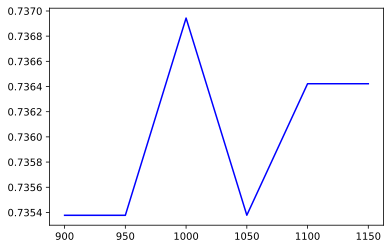

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

selected_features = ['number_of_exclamation', 'number_of_questionmark', 'number_of_hashtag',
                     'number_of_quote', 'number_of_stop', 'number_of_mention', ''
                     'affin', 'blob', 'apple', 'google', 'microsoft']

train = pd.merge(train_tf_idf, train_data[selected_features], left_index=True, right_index=True)
train_X, test_X, train_Y, test_Y = train_test_split(train, trainY, test_size=0.2)

score_lt = []
forest = np.arange(900, 1200, 50)

for i in forest:
    rfc = RandomForestClassifier(n_estimators = i ,random_state = 0)
    score = cross_val_score(rfc, train_X, train_Y, cv = 3).mean()
    score_lt.append(score)
    
idx = argmax(score_lt)
best_n = forest[idx]
print('Best accuracy = ', max(score_lt), ' is achieved by n_estimators = ', best_n)

plt.plot(forest, score_lt, 'b-')
plt.show()

Best accuracy =  0.7374653120160648  is achieved by max_depth =  170


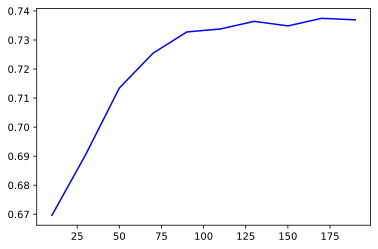

In [49]:
score_lt = []
forest = np.arange(10, 200, 20)

for i in forest:
    rfc = RandomForestClassifier(n_estimators = best_n ,random_state = 0, max_depth = i)
    score = cross_val_score(rfc, train_X, train_Y, cv = 3).mean()
    score_lt.append(score)
    
idx = argmax(score_lt)
best_d = forest[idx]
print('Best accuracy = ', max(score_lt), ' is achieved by max_depth = ', best_d)

plt.plot(forest, score_lt, 'b-')
plt.show()

Best accuracy =  0.7374653120160648  is achieved by min_samples_split =  2


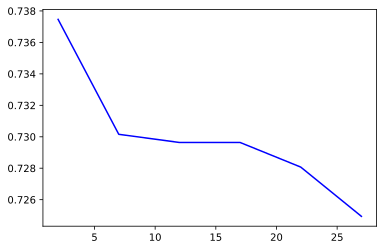

In [50]:
score_lt = []
forest = np.arange(2, 32, 5)

for i in forest:
    rfc = RandomForestClassifier(n_estimators = best_n ,random_state = 0, max_depth = best_d,
                                 min_samples_split = i)
    score = cross_val_score(rfc, train_X, train_Y, cv = 3).mean()
    score_lt.append(score)
    
idx = argmax(score_lt)
best_mss = forest[idx]
print('Best accuracy = ', max(score_lt), ' is achieved by min_samples_split = ', best_mss)

plt.plot(forest, score_lt, 'b-')
plt.show()

Best accuracy =  0.7004135576257965  is achieved by min_samples_leaf =  2


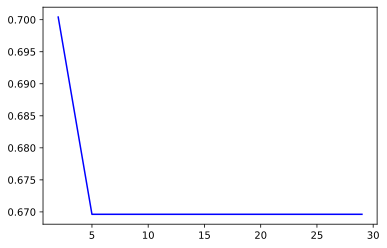

In [51]:
score_lt = []
forest = np.arange(2, 32, 3)

for i in forest:
    rfc = RandomForestClassifier(n_estimators = best_n ,random_state = 0, max_depth = best_d,
                                 min_samples_split = best_mss, min_samples_leaf = i)
    score = cross_val_score(rfc, train_X, train_Y, cv = 3).mean()
    score_lt.append(score)
    
idx = argmax(score_lt)
best_msl = forest[idx]
print('Best accuracy = ', max(score_lt), ' is achieved by min_samples_leaf = ', best_msl)

plt.plot(forest, score_lt, 'b-')
plt.show()

In [52]:
score_lt = []

rfc = RandomForestClassifier(n_estimators = best_n ,random_state = 0, max_depth = best_d,
                             min_samples_split = best_mss, min_samples_leaf = best_msl,
                             bootstrap = True)
score_T = cross_val_score(rfc, train_X, train_Y, cv = 3).mean()
print('Accuracy with bootstrap = True : ', score_T)


rfc = RandomForestClassifier(n_estimators = best_n ,random_state = 0, max_depth = best_d,
                             min_samples_split = best_mss, min_samples_leaf = best_msl,
                             bootstrap = False)
score_F = cross_val_score(rfc, train_X, train_Y, cv = 3).mean()
print('Accuracy with bootstrap = False : ', score_F)

best_bs = score_T > score_F

Accuracy with bootstrap = True :  0.7004135576257965
Accuracy with bootstrap = False :  0.7249392091548478


In [53]:
score_lt = []
forest = ['balanced', 'balanced_subsample']

rfc = RandomForestClassifier(n_estimators = best_n ,random_state = 0, max_depth = best_d,
                             min_samples_split = best_mss, min_samples_leaf = best_msl,
                             bootstrap = best_bs, class_weight = 'balanced')
score_T = cross_val_score(rfc, train_X, train_Y, cv = 3).mean()
print('Accuracy with class_weight = balanced : ', score_T)


rfc = RandomForestClassifier(n_estimators = best_n ,random_state = 0, max_depth = best_d,
                             min_samples_split = best_mss, min_samples_leaf = best_msl,
                             bootstrap = best_bs, class_weight = 'balanced_subsample')
score_F = cross_val_score(rfc, train_X, train_Y, cv = 3).mean()
print('Accuracy with class_weight = balanced_subsample : ', score_F)

best_cw = forest[score_T < score_F]

Accuracy with class_weight = balanced :  0.6946737898656306
Accuracy with class_weight = balanced_subsample :  0.6946737898656306


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


# Write data
### Write the best classifier's prediction

In [54]:
# testtxt
c1 = np.array(testtxt)
dix = {"testtxt": c1}
test_data = pd.DataFrame(dix)

add_extra_feature(test_data, test_data["testtxt"])

test_data['affin'] = test_data['testtxt'].apply(eva_afinn_score)
test_data['blob'] = test_data['testtxt'].apply(eva_blob_score)
test_data['traintxt'] = test_data['testtxt'].apply(clean_str)

eva_comp(test_data, test_data["testtxt"])
test_data['length'] =  test_data["testtxt"].apply(lambda x: (len(x)))

test_data["testtxt"] = test_data["testtxt"].apply(tokenize)
# test_data["testtxt"] = test_data["traintxt"].apply(tokenize)
test_data["testtxt"] = test_data["testtxt"].apply(stemming)
test_data["testtxt"] = test_data["testtxt"].apply(word_to_sen)

In [55]:
display(test_data)

,testtxt,number_of_quote,number_of_stop,number_of_exclamation,number_of_questionmark,number_of_hashtag,number_of_mention,number_of_comma,affin,blob,traintxt,apple,google,twitter,microsoft,length
0,what do we have to do to get flash on # ipad ?...,0.0,135,1,1,1,3,0,5.0,0.000000,what do we have to do to get flash on ipad ...,0,0,0,0,135
1,RT @ ruilifestyl : # googl the mixtap http : /...,0.0,58,0,0,1,1,0,0.0,0.000000,rt ruilifestyle google the mixtape,0,0,0,0,58
2,"appl to orang mayb , but # twitter is way more...",0.0,92,0,0,2,0,1,0.0,0.450000,apples to oranges maybe but twitter is way m...,0,0,0,0,92
3,thank @ appl for an OS updat that ha onli succ...,0.0,73,0,0,0,1,0,2.0,0.100000,thanks apple for an os update that has only s...,1,0,0,0,73
4,wht goin ON # twitter fam,0.0,25,0,0,1,0,0,0.0,0.000000,whts goin on twitter fam,0,0,0,0,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,doe anyon out there have some good onlin train...,0.0,135,0,1,2,0,0,3.0,0.700000,does anyone out there have some good online tr...,0,0,0,0,135
1024,# googl announc # nfc-base # android beam for ...,0.0,114,0,0,5,0,0,0.0,0.000000,google announces nfc based android beam for ...,0,0,0,0,114
1025,samsung e o googl lançam hoje o galaxi nexu e ...,0.0,99,0,0,2,0,0,0.0,0.000000,samsung e o google lan am hoje o galaxy nexus ...,0,1,0,0,99
1026,# microsoft eye A new approach to social # sea...,0.0,69,0,0,2,0,0,0.0,0.084848,microsoft eyes a new approach to social search,0,0,0,0,69


In [56]:
# test_tf_idf_features = vectorizer.transform(test_data["testtxt"]).toarray()
# test_tf_idf = pd.DataFrame(test_tf_idf_features)

test_bow_features = comp_vectorizer.transform(test_data["testtxt"]).toarray()
test_bow = pd.DataFrame(test_bow_features)

In [57]:
selected_features = ['number_of_exclamation', 'number_of_questionmark', 'number_of_hashtag',
                     'number_of_quote', 'number_of_stop', 'number_of_mention', ''
                     'affin', 'blob', 'apple', 'google', 'microsoft']

# test = pd.merge(test_tf_idf, test_data[selected_features], left_index=True, right_index=True)
# pred_Y = tfidf_rf_clf_model.predict(test)

test = pd.merge(test_bow, test_data[selected_features], left_index=True, right_index=True)
pred_Y = bow_rf_clf_model.predict(test)

print(pred_Y)
print(len(pred_Y))

['neutral' 'neutral' 'neutral' ... 'neutral' 'neutral' 'neutral']
1028


In [58]:
write_csv_kaggle_sub("BoW_submission.csv", pred_Y)

# Closing Remarks

**The best performance my model can achieve is balanced RandomForest classifier + meta features + BoW (This combination actually surprise me). It gives me the following hints:**

1. BoW can outperform TFIDF
2. Data pre-processing and cleansing is very important
3. Analyae the database before taking any actions
4. Meta features are very helpful, try your best to make use of it
5. The LSTM NN I trained above seems overfitted, it acts poor on the test data

**Before doing this assignment, I alse found some useful blogs that verified my ideas:**
1. How to use BERT and Google's word embedding: https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert#6.-Cross-validation
2. How to analyse your database: https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d
3. Feature Engineering (meta feature extraction, fantastic): https://www.analyticsvidhya.com/blog/2021/04/a-guide-to-feature-engineering-in-nlp/
4. How to analyse your database: https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/

**My special tricks summary:**
1. Handle special emoji. For example, '&lt;3' is the HTML code for a heart and suggests positive sentiment
2. Extract meta features in punctuations. It's intuitive that people will use '!!!', '....', '???' to express special sentiments
3. Make use of public sentiment analysis tools like Afinn and TextBlob
4. Be careful about the class unbalance will be really helpful (raise 2% acc)